# Bitcoin & Twitter

In [1]:
from pyspark import SparkContext
from pyspark.sql.types import *
from pyspark.sql import *
from pyspark.sql.functions import col, desc, asc, lit
from pyspark.sql import functions as F
import matplotlib.dates as mdates
import matplotlib.pyplot as plt
from matplotlib.pyplot import rc
import re
import yfinance as yf
import datetime
import folium
from geopy.geocoders import Nominatim

from pattern.en import sentiment

sc = SparkContext("local").getOrCreate()
sqlContext = SQLContext(sc)
spark = SparkSession(sc)
plt.style.use('ggplot')

21/11/17 22:43:47 WARN Utils: Your hostname, pop-os resolves to a loopback address: 127.0.1.1; using 192.168.0.8 instead (on interface wlp59s0)
21/11/17 22:43:47 WARN Utils: Set SPARK_LOCAL_IP if you need to bind to another address
21/11/17 22:43:48 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable
Using Spark's default log4j profile: org/apache/spark/log4j-defaults.properties
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).


## Data Exploration

### BITCOIN

 - Unix Timestamp - Date represented as epoc value
 - Date - date and time when the data point was collected
 - Symbol - Symbol of the currency
 - Open - Open value of the currency
 - High - Highest value of currency in the given minute
 - Low - Lowest value of currency in the given minute
 - Close - Close value of the currency in the given minute
 - Volume - Volume of the currency transacted in the given minute.

### TWITTER

 - user_name    The name of the user, as they’ve defined it.
 - user_location    The user-defined location for this account’s profile.
 - user_description	The user-defined UTF-8 string describing their account.
 - user_created	Time and date, when the account was created.
 - user_followers	The number of followers an account currently has.
 - user_friends	The number of friends a account currently has.
 - user_favourites	The number of favorites a account currently has
 - user_verified    When true, indicates that the user has a verified account
 - date UTC time and date when the Tweet was created
 - text The actual UTF-8 text of the Tweet
 - hashtags	All the other hashtags posted in the tweet along with #Bitcoin & #btc
 - source   Utility used to post the Tweet, Tweets from the Twitter website have a source value - web
 - is_retweet	Indicates whether this Tweet has been Retweeted by the authenticating user.

In [2]:
tweets_schema = StructType([
    StructField('user_name', StringType(), True),
    StructField('user_location', StringType(), True),
    StructField('user_description', StringType(), True),
    StructField('user_created', StringType(), True),
    StructField('user_followers', FloatType(), True),
    StructField('user_friends', IntegerType(), True),
    StructField('user_favourites', IntegerType(), True),
    StructField('user_verified', BooleanType(), True),
    StructField('date', StringType(), True),
    StructField('text', StringType(), True),
    StructField('hashtags', StringType(), True),
    StructField('source', StringType(), True),
    StructField('is_retweet', BooleanType(), True),
])


tweets_df = spark.read.csv(
    "./data/tweets.csv", 
    header=True,
    sep=',',
    multiLine=True,
    unescapedQuoteHandling="STOP_AT_CLOSING_QUOTE",
    schema=tweets_schema
)

tweets_df.show(3)

+-------------+---------------+--------------------+-------------------+--------------+------------+---------------+-------------+-------------------+--------------------+--------------------+-------------------+----------+
|    user_name|  user_location|    user_description|       user_created|user_followers|user_friends|user_favourites|user_verified|               date|                text|            hashtags|             source|is_retweet|
+-------------+---------------+--------------------+-------------------+--------------+------------+---------------+-------------+-------------------+--------------------+--------------------+-------------------+----------+
|DeSota Wilson|    Atlanta, GA|Biz Consultant, r...|2009-04-26 20:05:09|        8534.0|        7605|           4838|        false|2021-02-10 23:59:04|Blue Ridge Bank s...|         ['bitcoin']|    Twitter Web App|     false|
|     CryptoND|           null|😎 BITCOINLIVE is...|2019-10-17 20:12:10|        6769.0|        1532|     

In [4]:
# tweets_df = tweets_df.withColumn("date", datetime.datetime.strptime(str(col('date')), '%Y-%m-%d').strftime('%d/%m/%y')).filter((tweets_df.date > datetime.datetime(2020, 3, 20) )& (tweets_df.date < datetime.datetime(2021,9,10)))
tweets_df = tweets_df.withColumn("date", F.to_date(F.col("date"))).filter((tweets_df.date > datetime.datetime(2020, 3, 20) )& (tweets_df.date < datetime.datetime(2021,9,10)))
btc_stock=yf.Ticker("BTC-USD")
start = tweets_df.agg({"date": "min"}).collect()[0]
end = tweets_df.agg({"date": "max"}).collect()[0]
# print(datetime.datetime.strptime(str(start), '%Y-%m-%d'))
# print(datetime.datetime.strptime(str(end), '%Y-%m-%d'))
print(start['min(date)'])
print(end['max(date)'])
btc_stock = btc_stock.history(start=start['min(date)'], end=end['max(date)'])
btc_df = spark.createDataFrame(btc_stock)
btc_df.show()

2021-02-05
2021-08-26
+--------------+--------------+--------------+--------------+------------+---------+------------+
|          Open|          High|           Low|         Close|      Volume|Dividends|Stock Splits|
+--------------+--------------+--------------+--------------+------------+---------+------------+
|37475.10546875|38592.17578125|       36317.5|36926.06640625| 68838074392|        0|           0|
|  36931.546875|   38225.90625|36658.76171875|38144.30859375| 58598066402|        0|           0|
|38138.38671875|  40846.546875|38138.38671875|39266.01171875| 71326033653|        0|           0|
|39250.19140625| 39621.8359375|37446.15234375|38903.44140625| 65500641143|        0|           0|
|  38886.828125| 46203.9296875|38076.32421875|46196.46484375|101467222687|        0|           0|
| 46184.9921875|48003.72265625| 45166.9609375|46481.10546875| 91809846886|        0|           0|
|46469.76171875|47145.56640625|43881.15234375|44918.18359375| 87301089896|        0|           0

## Bitcoin

##### Open

In [5]:
btc_df.describe(["Open"]).show()

+-------+-----------------+
|summary|             Open|
+-------+-----------------+
|  count|              203|
|   mean|45867.88357258313|
| stddev|9524.087449234674|
|    min|   29796.28515625|
|    max|   63523.75390625|
+-------+-----------------+



##### High

In [6]:
btc_df.describe(["High"]).show()

+-------+-----------------+
|summary|             High|
+-------+-----------------+
|  count|              203|
|   mean|47271.04293988609|
| stddev|9620.880508685856|
|    min|       31006.1875|
|    max|   64863.09765625|
+-------+-----------------+



##### Low

In [7]:
btc_df.describe(["Low"]).show()

+-------+------------------+
|summary|               Low|
+-------+------------------+
|  count|               203|
|   mean|44269.886535945196|
| stddev|  9396.83141336401|
|    min|    28893.62109375|
|    max|    62208.96484375|
+-------+------------------+



##### Close

In [8]:
btc_df.describe(["Close"]).show()

+-------+------------------+
|summary|             Close|
+-------+------------------+
|  count|               203|
|   mean|45926.730603448275|
| stddev| 9506.198086922037|
|    min|    29807.34765625|
|    max|    63503.45703125|
+-------+------------------+



##### Volume

In [9]:
btc_df.describe(["Volume"]).show()

+-------+--------------------+
|summary|              Volume|
+-------+--------------------+
|  count|                 203|
|   mean|5.132496982655665E10|
| stddev|2.874821543643255...|
|    min|         18787986667|
|    max|        350967941479|
+-------+--------------------+



## TWITTER

In [10]:
tweets_df.count()

1207553

##### user_name
Should not be dropped lmao 

##### user_location

In [11]:
tweets_df.select(F.countDistinct("user_location")).show()
tweets_df.select([F.count(F.when(col("user_location").isNull(), "user_location"))]).show()

+-----------------------------+
|count(DISTINCT user_location)|
+-----------------------------+
|                        41044|
+-----------------------------+



+---------------------------------------------------------------+
|count(CASE WHEN (user_location IS NULL) THEN user_location END)|
+---------------------------------------------------------------+
|                                                         573570|
+---------------------------------------------------------------+



##### user_description

Should not be dropped lmao

##### user_created

In [12]:
tweets_df.describe(["user_created"]).show()

tweets_df.select([F.count(F.when(col("user_created").isNull(), "user_created"))]).show()

+-------+-------------------+
|summary|       user_created|
+-------+-------------------+
|  count|            1207553|
|   mean|               null|
| stddev|               null|
|    min|1970-01-01 00:00:00|
|    max|2021-08-26 23:33:23|
+-------+-------------------+



+-------------------------------------------------------------+
|count(CASE WHEN (user_created IS NULL) THEN user_created END)|
+-------------------------------------------------------------+
|                                                            0|
+-------------------------------------------------------------+



##### user_followers

In [13]:
tweets_df.select([F.count(F.when(col("user_followers").isNull(), "user_followers"))]).show()

+-----------------------------------------------------------------+
|count(CASE WHEN (user_followers IS NULL) THEN user_followers END)|
+-----------------------------------------------------------------+
|                                                                0|
+-----------------------------------------------------------------+



##### user_followers

In [14]:
tweets_df.select([F.count(F.when(col("user_followers").isNull(), "user_followers"))]).show()

+-----------------------------------------------------------------+
|count(CASE WHEN (user_followers IS NULL) THEN user_followers END)|
+-----------------------------------------------------------------+
|                                                                0|
+-----------------------------------------------------------------+



##### user_friends

In [15]:
tweets_df.select([F.count(F.when(col("user_friends").isNull(), "user_friends"))]).show()

+-------------------------------------------------------------+
|count(CASE WHEN (user_friends IS NULL) THEN user_friends END)|
+-------------------------------------------------------------+
|                                                       970778|
+-------------------------------------------------------------+



##### user_favourites

In [16]:
tweets_df.select([F.count(F.when(col("user_favourites").isNull(), "user_favourites"))]).show()

+-------------------------------------------------------------------+
|count(CASE WHEN (user_favourites IS NULL) THEN user_favourites END)|
+-------------------------------------------------------------------+
|                                                             970778|
+-------------------------------------------------------------------+



##### user_verified

In [17]:
tweets_df.select(F.count(F.when(col("user_verified").isNull(), "user_verified")),
                 F.count(F.when(col("user_verified") == "false", "user_verified")),
                 F.count(F.when(col("user_verified") == "true", "user_verified"))).show()

+---------------------------------------------------------------+---------------------------------------------------------------+--------------------------------------------------------------+
|count(CASE WHEN (user_verified IS NULL) THEN user_verified END)|count(CASE WHEN (user_verified = false) THEN user_verified END)|count(CASE WHEN (user_verified = true) THEN user_verified END)|
+---------------------------------------------------------------+---------------------------------------------------------------+--------------------------------------------------------------+
|                                                              0|                                                        1197833|                                                          9720|
+---------------------------------------------------------------+---------------------------------------------------------------+--------------------------------------------------------------+



##### date

In [18]:
tweets_df.select(F.countDistinct("date")).show()
tweets_df.select([F.count(F.when(col("date").isNull(), "date"))]).show()

+--------------------+
|count(DISTINCT date)|
+--------------------+
|                  77|
+--------------------+



+---------------------------------------------+
|count(CASE WHEN (date IS NULL) THEN date END)|
+---------------------------------------------+
|                                            0|
+---------------------------------------------+



##### text

In [19]:
tweets_df.select(F.count(F.when(col("text").isNull(), "text"))).show()

+---------------------------------------------+
|count(CASE WHEN (text IS NULL) THEN text END)|
+---------------------------------------------+
|                                            0|
+---------------------------------------------+



##### hashtags

In [20]:
tweets_df.select(F.countDistinct("hashtags")).show()
tweets_df.select([F.count(F.when(col("hashtags").isNull(), "hashtags"))]).show()

+------------------------+
|count(DISTINCT hashtags)|
+------------------------+
|                  284438|
+------------------------+



+-----------------------------------------------------+
|count(CASE WHEN (hashtags IS NULL) THEN hashtags END)|
+-----------------------------------------------------+
|                                                22011|
+-----------------------------------------------------+



##### source

In [21]:
tweets_df.select(F.countDistinct("source")).show()
tweets_df.select([F.count(F.when(col("source").isNull(), "source"))]).show()

+----------------------+
|count(DISTINCT source)|
+----------------------+
|                  1413|
+----------------------+



+-------------------------------------------------+
|count(CASE WHEN (source IS NULL) THEN source END)|
+-------------------------------------------------+
|                                             8851|
+-------------------------------------------------+



##### is_retweet

In [22]:
tweets_df.select(F.count(F.when(col("is_retweet").isNull(), "is_retweet")).alias("null values"),
                 F.count(F.when(col("is_retweet") == "false", "is_retweet")),
                 F.count(F.when(col("is_retweet") == "true", "is_retweet"))).show()

+-----------+---------------------------------------------------------+--------------------------------------------------------+
|null values|count(CASE WHEN (is_retweet = false) THEN is_retweet END)|count(CASE WHEN (is_retweet = true) THEN is_retweet END)|
+-----------+---------------------------------------------------------+--------------------------------------------------------+
|       5897|                                                  1201656|                                                       0|
+-----------+---------------------------------------------------------+--------------------------------------------------------+



## Preparing Data    Date|
+-------+-------------+

In [23]:
from pyspark.sql.functions import udf

def conv_to_int(val):
    if isinstance(val, str):
        return 0
    else:
        return float(val)

conv_to_int_udf = udf(lambda x : conv_to_int(x), IntegerType())

tweets_df = tweets_df.withColumn("user_followers", conv_to_int_udf(col("user_followers")))\
    .withColumn("user_friends", conv_to_int_udf(col("user_friends")))\
    .withColumn("user_favourites", conv_to_int_udf(col("user_favourites")))

### Text cleaning

In [24]:
def clean_text(text):
    if(isinstance(text, str)):
        text = text.replace("#","")
        text = re.sub('\\n', '', text)
        text = re.sub('https:\/\/\S+', '', text)
        return text
    else:
        return ""

clean_text_udf = udf(lambda x : clean_text(x), StringType())

tweets_df.withColumn("text", clean_text_udf(col("text")))

DataFrame[user_name: string, user_location: string, user_description: string, user_created: string, user_followers: int, user_friends: int, user_favourites: int, user_verified: boolean, date: date, text: string, hashtags: string, source: string, is_retweet: boolean]

### Generating impact score

In [25]:
from pyspark.sql.functions import struct

def generate_impact_score(tweet):
    coef_verified = 1.1 if tweet.user_verified else 1
    coef_hashtags = 1+(tweet.hashtags_len/20)
    return ((tweet.user_followers + (tweet.user_friends/4))*coef_verified*coef_hashtags)/100

generate_impact_score_udf = udf(lambda x : generate_impact_score(x), FloatType())

tweets_df.withColumn("impact_score", generate_impact_score_udf(struct([tweets_df[x] for x in tweets_df.columns])))

DataFrame[user_name: string, user_location: string, user_description: string, user_created: string, user_followers: int, user_friends: int, user_favourites: int, user_verified: boolean, date: date, text: string, hashtags: string, source: string, is_retweet: boolean, impact_score: float]

## Data visualisation

### Twitter

### Tweets / user

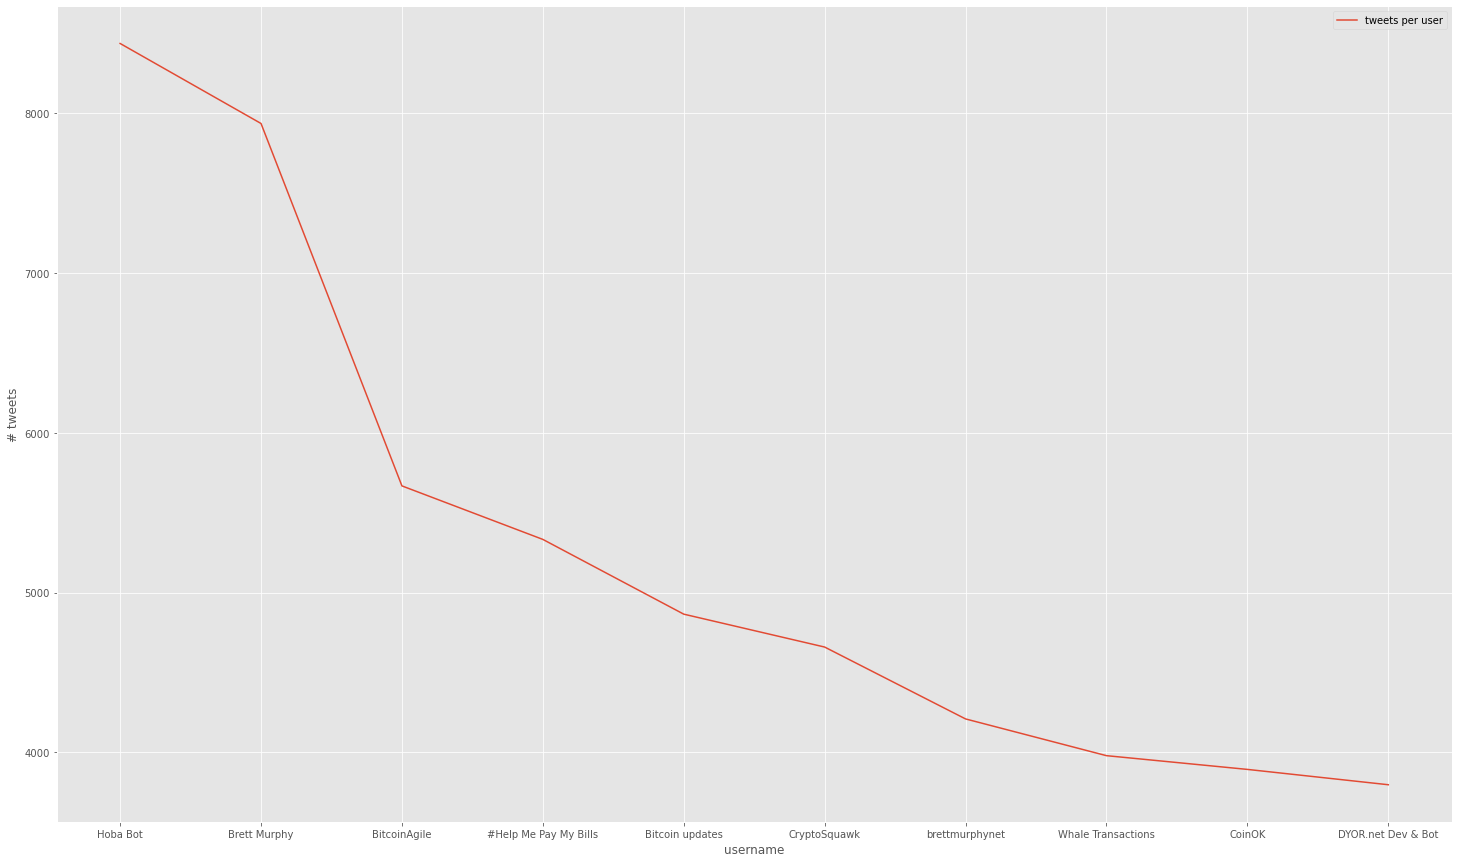

In [26]:
%matplotlib inline

user_volume = tweets_df.groupby("user_name").count().sort(desc("count"))

n = 10
x_rows = user_volume.limit(n).select("user_name").collect()
x = list(map(lambda r : str(r['user_name']), x_rows))

y_rows = user_volume.limit(n).select("count").collect()
y = list(map(lambda r : int(r['count']), y_rows))

rc('figure', figsize=(25, 15))
fig, ax = plt.subplots()
ax.plot(x, y,
        label='tweets per user')

ax.set_xlabel('username')
ax.set_ylabel('# tweets')
ax.legend()

### Bitcoin Value

In [27]:
# df_location = tweets_df.groupBy('user_location').count().sort(col("count").desc()).show()
geolocator = Nominatim(user_agent="example")
location_df = tweets_df.groupBy('user_location').count().filter("count >= 500").where("user_location not in ('Decentralized', 'Moon', '🇦🇺', 'Everywhere', 'Road Warrior', 'Mars', 'Cloud Engineer', 'Planet Earth', 'Earth', 'Blockchain', 'The Blockchain')").sort(col("count").desc()).dropna().collect()

def coords(location_string):
    try:
        location_obj = geolocator.geocode(location_string).raw
        return (location_obj['lat'], location_obj['lon'])
    except:
        return (20, 20)

locations = list(map(lambda r : [r['user_location'], r['count'], coords(r['user_location']) ], location_df)) 
map_tweets = folium.Map(location=[65,26], zoom_start=4)

for location_name, count, location_coords in locations:
    folium.Circle(location=location_coords,
                  popup = f"{location_name}: {count}",
                  radius = count*50,
                  color="crimson",
                  fill_color="crimson",
                  tooltip=count).add_to(map_tweets)
map_tweets

In [28]:
date_df = tweets_df.withColumn("date", F.to_date(F.col("date")))
date_df = date_df. groupby("date").count().dropna().sort(asc("date")).filter((date_df.date > datetime.datetime(2020, 3, 20) )& (date_df.date < datetime.datetime.today()))
date_df.sort(desc("date")).show(1)
date_df.sort(asc("date")).show(1)
x_rows = date_df.select("date").collect() 
x = list(map(lambda r : (r['date']), x_rows)) 
y_rows = date_df.select("count").collect() 
tweets_y = list(map(lambda r : int(r['count']), y_rows))

+----------+-----+
|      date|count|
+----------+-----+
|2021-08-26|39129|
+----------+-----+
only showing top 1 row



+----------+-----+
|      date|count|
+----------+-----+
|2021-02-05| 1692|
+----------+-----+
only showing top 1 row



In [29]:
y_rows = btc_df.select("Volume").collect() 
btc_y = list(map(lambda r : float(r['Volume']), y_rows))

In [30]:
print(btc_df.select("Volume").count())
print(len(tweets_y))

203
77


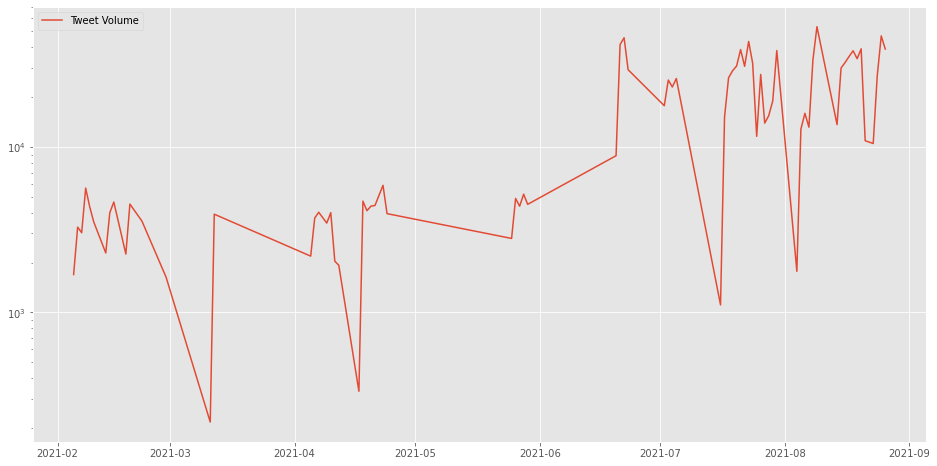

In [31]:
fig, ax = plt.subplots(figsize=(16,8))
ax.plot(x,tweets_y,label='Tweet Volume')
ax.set_yscale('log')
ax.tick_params(axis='y')
lines, labels = ax.get_legend_handles_labels()
ax.legend(lines, labels, loc=0)

plt.show()

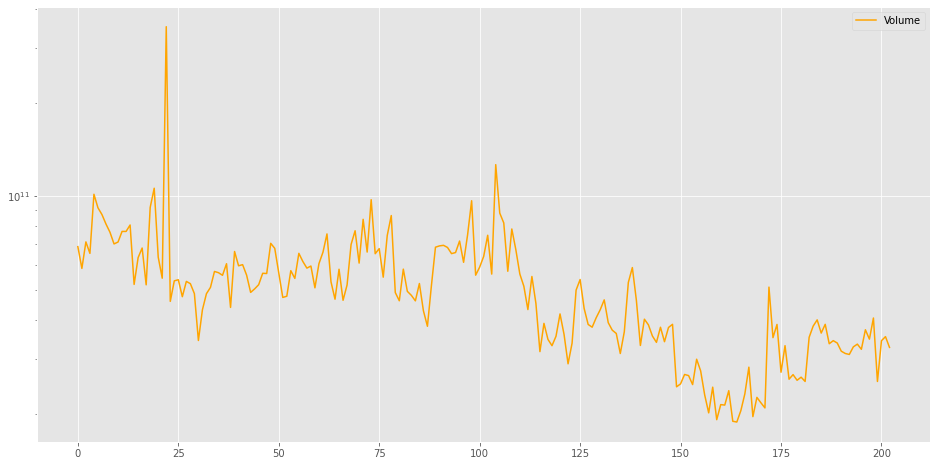

In [32]:
fig, ax2 = plt.subplots(figsize=(16,8))
ax2.plot(btc_y,color='orange',label='Volume')
ax2.set_yscale('log')
ax2.tick_params(axis='y')

lines2, labels2 = ax2.get_legend_handles_labels()
ax2.legend(lines2,labels2, loc=0)
plt.show()

In [38]:

tweet_text = tweets_df.select("text").collect()[0:30]

sentiments = [(x.text, sentiment(x.text)) for x in tweet_text]


for i, v in enumerate(sentiments):
	print(v)
	if i == 20:
		break





('Blue Ridge Bank shares halted by NYSE after #bitcoin ATM announcement https://t.co/xaaZmaJKiV @MyBlueRidgeBank… https://t.co/sgBxMkP1SI', (0.0, 0.1))
('😎 Today, that\'s this #Thursday, we will do a ""🎬 Take 2"" with our friend @LeoWandersleb, #Btc #wallet #security expe… https://t.co/go6aDgRml5', (0.5, 1.0))
('Guys evening, I have read this article about BTC and would like to share with you all - https://t.co/QxCZgmuy3B… https://t.co/o6wn7ppkVY', (0.0, 0.0))
('$BTC A big chance in a billion! Price: \\4872644.0 (2021/02/11 08:51) #Bitcoin #FX #BTC #crypto', (0.0, 0.1))
('This network is secured by 9 508 nodes as of today. Soon, the biggest bears will recognise: #BTC in too big to fail… https://t.co/1XovDA8rKw', (0.0, 0.1))
('💹 Trade #Crypto on #Binance \n\n📌 Enjoy #Cashback 10% of the Trading fee\n📌 Sign up link 👉 https://t.co/T4WttWeohc… https://t.co/Fc7dG5oI8W', (0.4, 0.5))
("&lt;'fire' &amp; 'man'&gt;\n#Bitcoin #Crypto #BTC https://t.co/CV9IyODy55", (0.0, 0.0))
('🔄 Prices update in